In [1]:
# Import necessary libraries

import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random 

2023-11-06 19:29:19.457992: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-06 19:29:19.458023: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-06 19:29:19.458053: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-06 19:29:19.467925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 19:29:20.363973: W tensorflow/compiler/

In [2]:
# Initial settings

df = pd.read_csv('data/creditcard.csv')

random_seed = 42
train_sample = 200000
validation_size = 0.2
ratio_fraud = 15

np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Distributing normally

df['log10_amount'] = np.log10(df.Amount + 0.00001)

In [5]:
# Dropping the unnecessary columns
df = df.drop(['Time', 'Amount'], axis=1)

# Splitting the data by class
fraud = df[df.Class == 1]
clean = df[df.Class == 0]

# Undersampling the clean transactions to balance the dataset. It ensures that you have 15 
# times as many non-fraudulent transactions as fraudulent ones. 
clean_undersampled = clean.sample(int(len(fraud) * ratio_fraud), random_state = random_seed)

# Concatenating the fraud and clean_undersampled
visualisation_initial = pd.concat([fraud, clean_undersampled])
column_names = list(visualisation_initial.drop('Class', axis=1).columns)

# Isolate features from labels 
features, labels = visualisation_initial.drop('Class', axis=1).values, visualisation_initial.Class.values

In [6]:
print(f"The non-fraud dataset has been undersampled from {len(clean):,} to {len(clean_undersampled):,}. This represents a ratio of {ratio_fraud}:1 to fraud.")

The non-fraud dataset has been undersampled from 284,315 to 7,380. This represents a ratio of 15:1 to fraud.


In [7]:
# Import required libraries for t-SNE: t-Distributed Stochastic Neighbor Embedding
from sklearn.manifold import TSNE

# Define a function for t-SNE scatter plot
def tsne_scatter(features, labels, dimensions=2, save_as='my_graph.png'):
    # Perform t-SNE dimensionality reduction
    features_embedded = TSNE(n_components=dimensions, random_state=random_seed).fit_transform(features)
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Check dimensions for 3D plot
    if dimensions == 3:
        ax = fig.add_subplot(111, projection='3d')

    # Plot data points for fraud and clean transactions
    ax.scatter(
        *zip(*features_embedded[np.where(labels == 1)]),
        marker='o',
        color='r',
        s=2,
        alpha=0.7,
        label='Fraud'
    )
    ax.scatter(
        *zip(*features_embedded[np.where(labels == 0)]),
        marker='o',
        color='g',
        s=2,
        alpha=0.3,
        label='Clean'
    )

    # Add a legend and save the plot
    plt.legend(loc='best')
    plt.savefig(save_as)
    plt.show

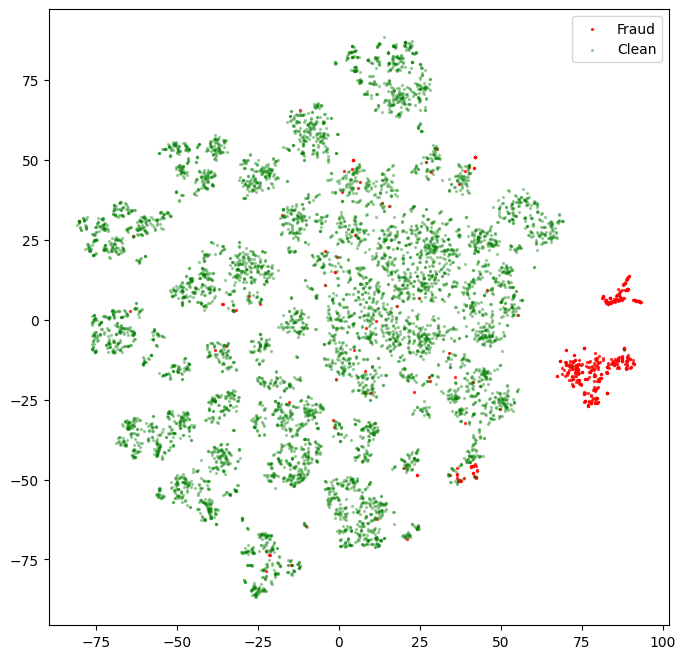

In [8]:
tsne_scatter(features, labels, dimensions=2, save_as='plots/t-SNE_initial2d.png')

In [9]:
clean.shape

(284315, 30)

In [10]:
fraud.shape

(492, 30)

In [11]:
# Shuffling the training set
clean = clean.sample(frac=1).reset_index(drop=True)

# Only the clean
X_train = clean.iloc[:train_sample].drop('Class', axis=1)

# Remaining clean dataset + fraud
X_test = pd.concat([clean.iloc[train_sample:], fraud]).sample(frac=1)

In [12]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,log10_amount
0,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,...,-0.058040,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,-0.119181
1,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,...,-0.081298,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0.621177
2,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,...,0.065716,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,1.176092
3,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,...,-0.169706,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,1.755875
4,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,...,-0.282777,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,-5.000000


In [13]:
X_test.shape

(84807, 30)

In [14]:
X_test.Class.value_counts()

Class
0    84315
1      492
Name: count, dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

# Splitting into train and valid
X_train, X_valid = train_test_split(X_train, test_size=validation_size, random_state=random_seed)

X_test, y_test = X_test.drop('Class', axis=1).values, X_test.Class.values

In [16]:
# Building the pipeline
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [17]:
pipeline.fit(X_train)

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [18]:
# Applying transformations with acquired parameters

X_train_transformed = pipeline.transform(X_train)
X_valid_transformed = pipeline.transform(X_valid)

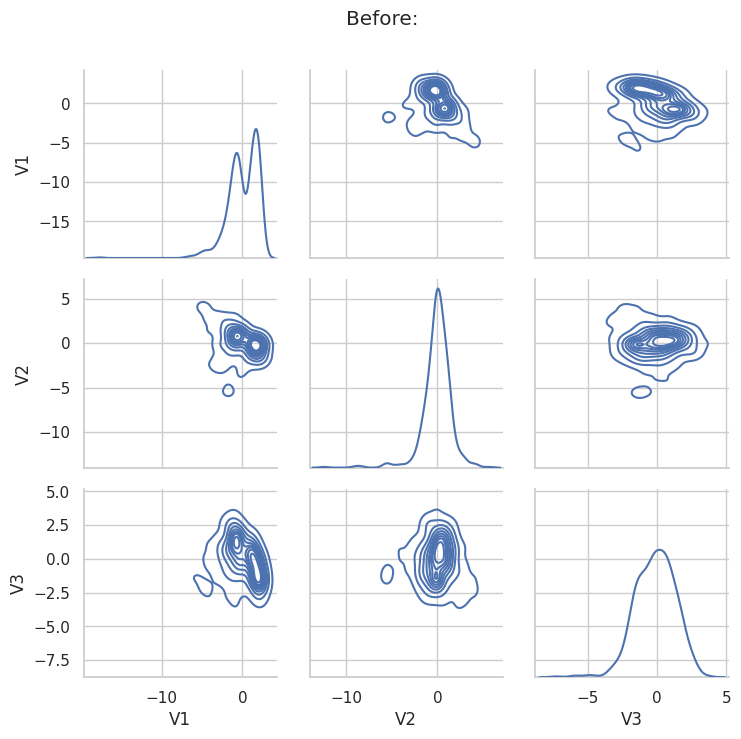

In [19]:
sns.set(style='whitegrid')

g = sns.PairGrid(X_train.iloc[:,:3].sample(600, random_state=random_seed))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Before:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

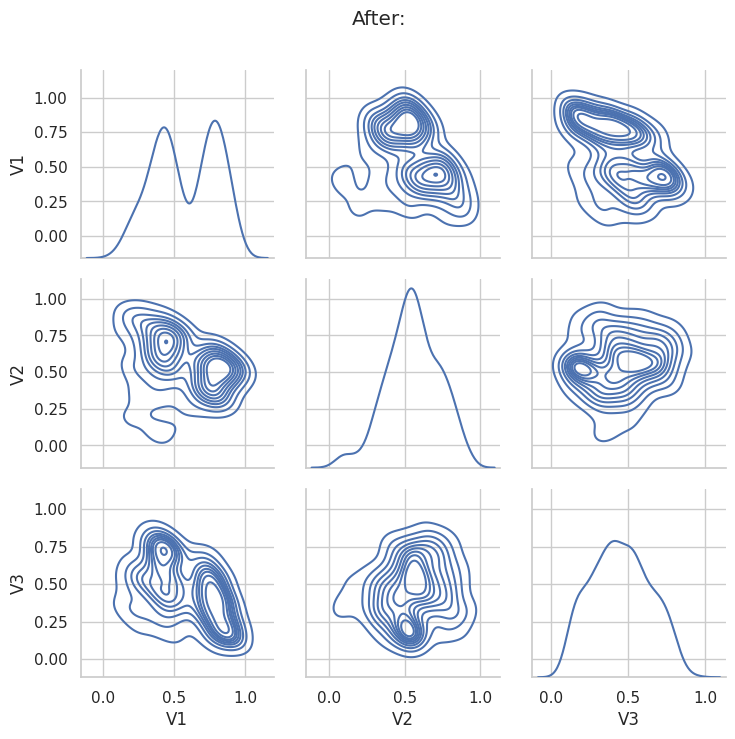

In [20]:
g = sns.PairGrid(pd.DataFrame(X_train_transformed, columns=column_names).iloc[:,:3].sample(600, random_state=random_seed))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot);

In [21]:
input_dim = X_train_transformed.shape[1]
batch_size = 256
epochs = 100

autoencoder = tf.keras.models.Sequential([
    
    # The Encoder Part - deconstructing/compressing
    tf.keras.layers.Dense(input_dim, activation='elu', input_shape=(input_dim, )), 
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(2, activation='elu'), # This is the bottleneck layer which represents the compressed representation of the data
    
    # The Decoder Part - reconstructing
    tf.keras.layers.Dense(4, activation='elu'),
    tf.keras.layers.Dense(8, activation='elu'),
    tf.keras.layers.Dense(16, activation='elu'),
    tf.keras.layers.Dense(input_dim, activation='elu')
    
])

autoencoder.compile(optimizer="adam", 
                    loss="mse",
                    metrics=["acc"])

autoencoder.summary();

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 16)                480       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 8)                 4

2023-11-06 19:29:59.061797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 19:29:59.122826: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
from datetime import datetime

# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

log_subdir = f'{yyyymmddHHMM}_batch{batch_size}_layers{len(autoencoder.layers)}'

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='weights/autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

# The Callbacks allow the code to continue as long as the model is reducing the training loss
# and only save the weights for the model with the lowest validation loss.
cb = [early_stop, save_model]

In [23]:
history = autoencoder.fit(
    X_train_transformed, X_train_transformed,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=cb,
    validation_data=(X_valid_transformed, X_valid_transformed)
);

Epoch 1/100
625/625 [==============================] - 3s 2ms/step - loss: 0.0307 - acc: 0.2294 - val_loss: 0.0171 - val_acc: 0.2609
Epoch 2/100
 81/625 [==>...........................] - ETA: 1s - loss: 0.0171 - acc: 0.2516

/home/drishya/Desktop/ML and DL Projects/anomalyAutoEncoderCreditCard/venv/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 1s 2ms/step - loss: 0.0164 - acc: 0.2589 - val_loss: 0.0152 - val_acc: 0.2747
Epoch 3/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0147 - acc: 0.3291 - val_loss: 0.0145 - val_acc: 0.3388
Epoch 4/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0144 - acc: 0.3402 - val_loss: 0.0142 - val_acc: 0.3421
Epoch 5/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0140 - acc: 0.3346 - val_loss: 0.0139 - val_acc: 0.3287
Epoch 6/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0138 - acc: 0.3271 - val_loss: 0.0137 - val_acc: 0.3257
Epoch 7/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0137 - acc: 0.3368 - val_loss: 0.0137 - val_acc: 0.3396
Epoch 8/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0136 - acc: 0.3514 - val_loss: 0.0135 - val_acc: 0.3568
Epoch 9/100
625/625 [==============================] - 1s 2ms/step - loss: 0.0133

In [24]:
# Applying the transfomation pipeline to our test set
X_test_transformed = pipeline.transform(X_test)

# Paassing the data through the trained autoencoder
reconstructions = autoencoder.predict(X_test_transformed)

/home/drishya/Desktop/ML and DL Projects/anomalyAutoEncoderCreditCard/venv/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but Normalizer was fitted with feature names
  warnings.warn(


2651/2651 [==============================] - 2s 716us/step


In [25]:
# Calculating the mean squared error
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)

In [26]:
mse

array([0.00668122, 0.0075058 , 0.00664749, ..., 0.01161111, 0.01956357,
       0.00774261])

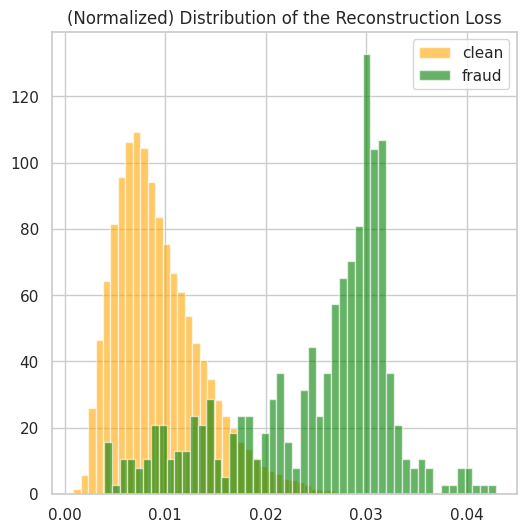

In [27]:
clean = mse[y_test==0]
fraud = mse[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="orange")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="green")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

In [28]:
threshold = 3

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > threshold

In [29]:
np.sum(outliers)

2108

In [30]:
np.size(z_scores)

84807

In [31]:
# Confusion matrix on MAD outliers
from sklearn.metrics import (confusion_matrix, 
                             precision_recall_curve)

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, fn, tp) = cm.flatten()

In [32]:
cm

array([[82572,  1743],
       [  127,   365]])

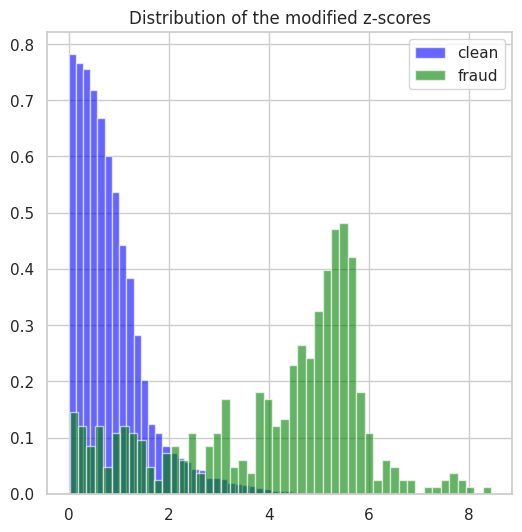

In [33]:
clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="blue")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="green")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()

In [34]:
# Only building the encoders that gets us to bottleneck
encoder = tf.keras.models.Sequential(autoencoder.layers[:5])
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 16)                480       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 2)                 10        
                                                                 
Total params: 1532 (5.98 KB)
Trainable params: 1532 (5.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
# Taking all the fraud, undersampling clean
fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * ratio_fraud, ]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)

246/246 [==============================] - 0s 770us/step


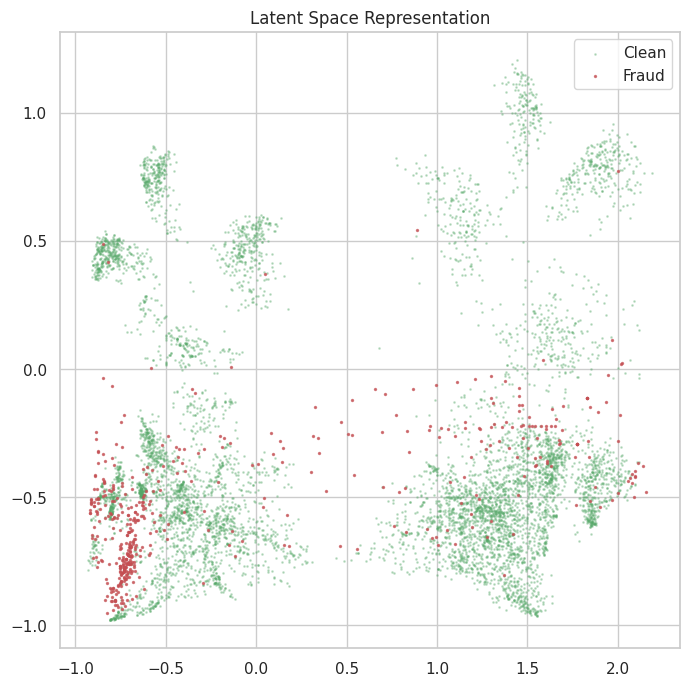

In [36]:
X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(8, 8))
plt.scatter(X[labels==0], y[labels==0], s=1, c='g', alpha=0.3, label='Clean')
plt.scatter(X[labels==1], y[labels==1], s=2, c='r', alpha=0.7, label='Fraud')

# labeling
plt.legend(loc='best')
plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('plots/latent_representation_2d');
plt.show()